In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline
import xarray as xr
import numpy as np
import os
from pprint import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy 
from datetime import datetime
import cmocean
import pandas as pd
#import modules.basic_stats as bst
#import modules.plotting_module as pltm
import intake
import xarray
import xesmf as xe
import cftime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point

In [2]:
# siconc/tos/sss/psl canesm2, canesm5

# siconc in ocean only experiments

# siconc/tos/sss in piControl experiments

# siconc/tos/sss in historical experiments

In [2]:
start = '1981-01-01'
end   = '2010-12-31'

# Target grid to remap to. Here a standard 1x1 grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-40, 90, 0.25)),
                     'lon': (['lon'], np.arange(-180, 180, 0.25)),
                    }
                   )

# Location of the datasets used for the GMD figures. Should not need changing.
obs_data_path='/home/ncs001/site5/u1_data/canesm5-analysis/cmip6_gmd_figures'

In [6]:
#NSIDC data is fractional - convert to percent to compare with CanESM5
path=os.path.join(obs_data_path, 'input_data/processed_data/remap-woa09_seaice_conc_monthly_nh_1981-2010_v03r01.nc')
siconc_NSIDC_nh_rm = xr.open_dataset(path)['goddard_merged_seaice_conc_monthly'].sel(time=slice(start, end))*100

In [5]:
# ERA5 psl
ds_era5_psl = xr.open_dataset('/home/ncs001/site5/u1_data/canesm5-analysis/cmip6_gmd_figures/obs/NEIL/era5/era5_psl_monthlymean_1979-2019.nc')

regridder_era5_psl = xe.Regridder(ds_era5_psl, ds_out, 'bilinear', periodic=True)
ds_era5_psl_rm = regridder_era5_psl(ds_era5_psl).sel(time=slice(start, end))

In [6]:
# HadISST
ds_hadisst = xr.open_dataset('/home/ncs001/site5/u1_data/canesm5-analysis/cmip6_gmd_figures/obs/HadISST_sst.nc')
regridder_hadisst = xe.Regridder(ds_hadisst, ds_out, 'bilinear', periodic=True)
ds_hadisst_rm = regridder_hadisst(ds_hadisst).sel(time=slice(start, end))

: 

: 

In [ ]:
# WOA13 SSS
ds_woa_sss = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/salinity/decav/1.00/woa18_decav_s03_01.nc', decode_times=False).isel(depth=0)
regridder_woa = xe.Regridder(ds_woa_sss, ds_out, 'bilinear', periodic=True)
ds_woa_sss_rm = regridder_woa(ds_woa_sss)

In [3]:
def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    return ds

In [4]:
# Load CanESM5 data
# This is the location of the intake database
cat_url_cmip6 = "/home/scrd106/model_output/intake-catalogues/cccma_cmip6.json"

col = intake.open_esm_datastore(cat_url_cmip6)

query = dict(variable_id=['siconc', 'tos', 'sos', 'psl'], table_id=['SImon', 'Omon', 'Amon'], source_id='CanESM5', 
             experiment_id='historical', member_id='r1i1p2f1')
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper)

for k in dset_dict.keys():
    if 'SImon' in k:
        canesm5p1_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'Omon' in k:
        canesm5p1_tos_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()   
    elif 'Amon' in k:
        canesm5p1_psl_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()   


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
# remap CanESM5 data
regridder_canesm5 = xe.Regridder(canesm5p1_ds, siconc_NSIDC_nh_rm, 'bilinear', periodic=True)
canesm5p2_ds_rm = regridder_canesm5(canesm5p1_ds)

regridder_canesm5_tos = xe.Regridder(canesm5p1_tos_ds, ds_out, 'bilinear', periodic=True)
canesm5p2_tos_ds_rm = regridder_canesm5_tos(canesm5p1_tos_ds)

regridder_canesm5_psl = xe.Regridder(canesm5p1_psl_ds, ds_out, 'bilinear', periodic=True)
canesm5p2_psl_ds_rm = regridder_canesm5_psl(canesm5p1_psl_ds)

/home/ncs001/.conda/envs/py3_sofia_analysis/lib/python3.9/site-packages/xarray/core/dataarray.py:848: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [ ]:
# Load CanESM2 data
cat_url_cmip5 = "/home/scrd106/model_output/intake-catalogues/cccma_cmip5.json"

col = intake.open_esm_datastore(cat_url_cmip5)

query = dict(variable=['sic', 'tos', 'sos', 'psl'], model='CanESM2', experiment='historical', frequency='mon',
             ensemble_member='r1i1p1')
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper)
for k in dset_dict.keys():
    if 'OImon' in k:
        canesm2_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'Omon' in k:
        canesm2_tos_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'Amon' in k:
        canesm2_psl_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()        


--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'


In [ ]:
# remap CanESM2 data
regridder_canesm2 = xe.Regridder(canesm2_ds, siconc_NSIDC_nh_rm, 'bilinear', periodic=True)
canesm2_ds_rm = regridder_canesm2(canesm2_ds)

regridder_canesm2_tos = xe.Regridder(canesm2_tos_ds, ds_out, 'bilinear', periodic=True)
canesm2_tos_ds_rm = regridder_canesm2_tos(canesm2_tos_ds)

regridder_canesm2_psl = xe.Regridder(canesm2_psl_ds, ds_out, 'bilinear', periodic=True)
canesm2_psl_ds_rm = regridder_canesm2_psl(canesm2_psl_ds)

/home/ncs001/.conda/envs/py3_sofia_analysis/lib/python3.9/site-packages/xarray/core/dataarray.py:848: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [8]:
# Load historical experiment data
ds_varcons_his = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/users/scrd103/v5.0-his-varsno/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-v5.0-his-varsno/historical/r1i1p2f1/SImon/siconc/gn/v20190429/siconc_SImon_CanESM5-v5.0-his-varsno_historical_r1i1p2f1_gn_185001-201412.nc')
varcons_ds_rm = regridder_canesm5(ds_varcons_his).sel(time=slice(start, end)).squeeze()

ds_cons02 = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/users/rdy001/esm-hst-sc/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-esm-hst-sc/historical/r1i1p1f1/SImon/siconc/gn/v20190429/siconc_SImon_CanESM5-esm-hst-sc_historical_r1i1p1f1_gn_185001-201412.nc')
cons02_ds_rm = regridder_canesm5(ds_cons02).sel(time=slice(start, end)).squeeze()     

# nudged runs
ds_nudge_1950 = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/users/rsk001/rsk2052-01/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-rsk2052-01/historical/r1i1p1f1/SImon/siconc/gn/v20190429/siconc_SImon_CanESM5-rsk2052-01_historical_r1i1p1f1_gn_195001-202112.nc')
ds_nudge_1950_rm = regridder_canesm5(ds_nudge_1950).sel(time=slice(start, end)).squeeze()


ds_nudge_1980 = xr.open_mfdataset('/space/hall6/sitestore/eccc/crd/ccrn/users/rsk001/rsk2052-04/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-rsk2052-04/historical/r1i1p1f1/SImon/siconc/gn/*/*.nc')
ds_nudge_1980_rm = regridder_canesm5(ds_nudge_1980).sel(time=slice(start, end)).squeeze()

ds_nudge_1990 = xr.open_mfdataset('/space/hall6/sitestore/eccc/crd/ccrn/users/rsk001/rsk2052-05/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-rsk2052-05/historical/r1i1p1f1/SImon/siconc/gn/*/*.nc')
ds_nudge_1990_rm = regridder_canesm5(ds_nudge_1990).sel(time=slice(start, end)).squeeze()

/home/ncs001/.conda/envs/py3_sofia_analysis/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/ncs001/.conda/envs/py3_sofia_analysis/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/ncs001/.conda/envs/py3_sofia_analysis/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [10]:
# Get March mean concentration
siconc_NSIDC_nh_rm_mar = siconc_NSIDC_nh_rm.sel(time=siconc_NSIDC_nh_rm['time.month']==3).mean(dim='time')
#canesm2_ds_rm_mar = canesm2_ds_rm.sel(time=canesm2_ds_rm['time.month']==3).mean(dim='time').sic
canesm5p2_ds_rm_mar = canesm5p2_ds_rm.sel(time=canesm5p2_ds_rm['time.month']==3).mean(dim='time').siconc
#siconc_anom_mar_canesm2 = ( canesm2_ds_rm_mar - siconc_NSIDC_nh_rm_mar).load()
siconc_anom_mar_canesm5 = ( canesm5p2_ds_rm_mar - siconc_NSIDC_nh_rm_mar).load()

# historical experiments
varcons_ds_rm_mar = varcons_ds_rm.sel(time=varcons_ds_rm['time.month']==3).mean(dim='time').siconc
siconc_anom_mar_varcons = ( varcons_ds_rm_mar - siconc_NSIDC_nh_rm_mar).load()

cons02_ds_rm_mar = cons02_ds_rm.sel(time=cons02_ds_rm['time.month']==3).mean(dim='time').siconc
siconc_anom_mar_cons02 = ( cons02_ds_rm_mar - siconc_NSIDC_nh_rm_mar).load()

# nudged runs
nudge_1950_mar = ds_nudge_1950_rm.sel(time=ds_nudge_1950_rm['time.month']==3).mean(dim='time').siconc
siconc_anom_mar_ds_nudge_1950 = ( nudge_1950_mar - siconc_NSIDC_nh_rm_mar).load()

nudge_1980_mar = ds_nudge_1980_rm.sel(time=ds_nudge_1980_rm['time.month']==3).mean(dim='time').siconc
siconc_anom_mar_ds_nudge_1980 = ( nudge_1980_mar - siconc_NSIDC_nh_rm_mar).load()

nudge_1990_mar = ds_nudge_1990_rm.sel(time=ds_nudge_1990_rm['time.month']==3).mean(dim='time').siconc
siconc_anom_mar_ds_nudge_1990 = ( nudge_1990_mar - siconc_NSIDC_nh_rm_mar).load()

In [ ]:
# Get March means
ds_era5_psl_rm_mar = ds_era5_psl_rm.sel(time=ds_era5_psl_rm['time.month']==3).mean(dim='time')
ds_hadisst_rm_mar = ds_hadisst_rm.sel(time=ds_hadisst_rm['time.month']==3).mean(dim='time')

canesm2_tos_ds_rm_mar = canesm2_tos_ds_rm.sel(time=canesm2_tos_ds_rm['time.month']==3).mean(dim='time')
canesm5p2_tos_ds_rm_mar = canesm5p2_tos_ds_rm.sel(time=canesm5p2_tos_ds_rm['time.month']==3).mean(dim='time')

canesm2_psl_ds_rm_mar = canesm2_psl_ds_rm.sel(time=canesm2_psl_ds_rm['time.month']==3).mean(dim='time')
canesm5p2_psl_ds_rm_mar = canesm5p2_psl_ds_rm.sel(time=canesm5p2_psl_ds_rm['time.month']==3).mean(dim='time')

# anomalies
canesm2_tos_ds_rm_mar_anom = (canesm2_tos_ds_rm_mar.tos -273.15 - ds_hadisst_rm_mar.sst).compute()
canesm5p2_tos_ds_rm_mar_anom = (canesm5p2_tos_ds_rm_mar.tos - ds_hadisst_rm_mar.sst).compute()

canesm2_sos_ds_rm_mar_anom = (canesm2_tos_ds_rm_mar.sos  - ds_woa_sss_rm.s_an).compute().squeeze()
canesm5p2_sos_ds_rm_mar_anom = (canesm5p2_tos_ds_rm_mar.sos - ds_woa_sss_rm.s_an).compute().squeeze()

canesm2_psl_ds_rm_mar_anom = (canesm2_psl_ds_rm_mar.psl - ds_era5_psl_rm_mar.msl).compute()
canesm5p2_psl_ds_rm_mar_anom = (canesm5p2_psl_ds_rm_mar.psl - ds_era5_psl_rm_mar.msl).compute()

In [16]:
fig = plt.figure(figsize=(12,10))
projection=ccrs.LambertAzimuthalEqualArea(central_longitude=270, central_latitude=60)
#projection=ccrs.LambertConformal(central_longitude=270, central_latitude=60)

#projection=ccrs.PlateCarree()
axl = plt.subplot(1,2,1,projection=projection)

levels=np.arange(-100,101,10)
axl.contourf(siconc_anom_mar_canesm2.lon, siconc_anom_mar_canesm2.lat, 
               siconc_anom_mar_canesm2, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
axl.contour(canesm2_ds_rm_mar.lon, canesm2_ds_rm_mar.lat, canesm2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axr = plt.subplot(1,2,2,projection=projection)
axr.contourf(siconc_anom_mar_canesm5.lon, siconc_anom_mar_canesm5.lat, 
               siconc_anom_mar_canesm5, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
axr.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')


axl.set_title('CanESM2')
axr.set_title('CanESM5-0_p2')
axl. text(1.1,1.1, 'March concentration anomaly vs NSIDC', transform=axl.transAxes, ha='center', fontweight='bold')
for ax in [axl, axr]:
    ax.coastlines(resolution='110m')
    ax.gridlines()
    ax.set_extent([275,350,50,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    
fig.savefig('siconc_bias_CanESM2_CanESM5.png', bbox_inches='tight', dpi=300)

# Plot siconc, sst, psl anomalies together

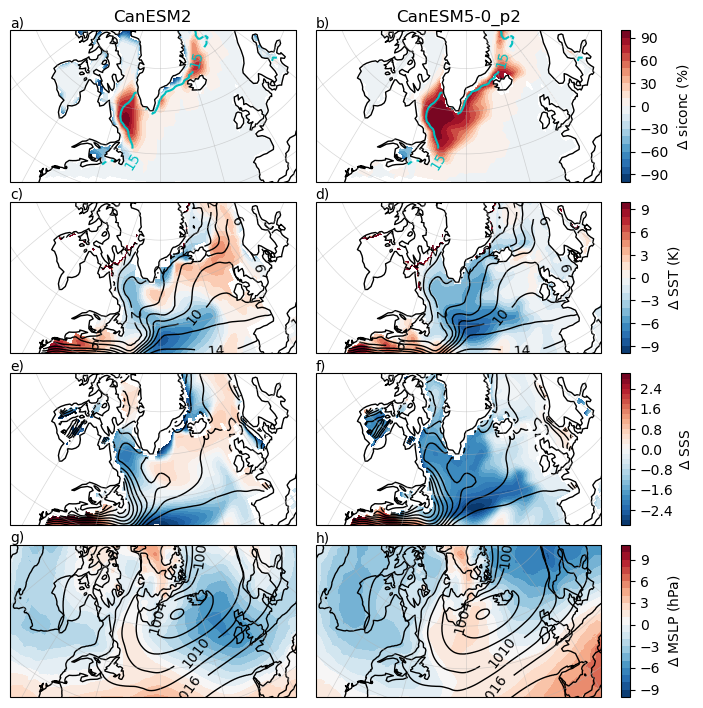

In [27]:
fig = plt.figure(figsize=(8,14))

projection=ccrs.LambertAzimuthalEqualArea(central_longitude=320, central_latitude=60)
axes_class = (GeoAxes,
                  dict(projection=projection))

obs_contours={'colors':'k', 'linewidths':1}
model_contours={'colors':'k', 'linewidths':1}

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(4, 2),
                    axes_pad=0.2,
                    cbar_location='right',
                    cbar_mode='edge',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05

# siconc
levels=np.arange(-100,101,10)
ax = grid[0]
ax.set_title('CanESM2')
ax.contourf(siconc_anom_mar_canesm2.lon, siconc_anom_mar_canesm2.lat, 
               siconc_anom_mar_canesm2, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
#mc=ax.contour(canesm2_ds_rm_mar.lon, canesm2_ds_rm_mar.lat, canesm2_ds_rm_mar, [15], 
#                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

ax = grid[1]
ax.set_title('CanESM5-0_p2')
cb_sicn=ax.contourf(siconc_anom_mar_canesm5.lon, siconc_anom_mar_canesm5.lat, 
               siconc_anom_mar_canesm5, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
#mc=ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
#                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

for ax in grid[0:2]:
    oc = ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), linewidth=1, colors='c')

    ax.clabel(oc, oc.levels, inline=True)

grid.cbar_axes[0].colorbar(cb_sicn,extend='both', label =r'$\Delta$ siconc (%)')

#===================================================================================
# TOS
obs_contours={'colors':'k', 'linewidths':1}
levels=np.arange(-10,11,1)
ax = grid[2]
cb_tos=ax.contourf(canesm2_tos_ds_rm_mar_anom.lon, canesm2_tos_ds_rm_mar_anom.lat, 
               canesm2_tos_ds_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
#mc = ax.contour(canesm2_tos_ds_rm_mar.lon, canesm2_tos_ds_rm_mar.lat, 
#               canesm2_tos_ds_rm_mar.tos-273.15, levels=np.arange(-2,18,2), **model_contours,
#               transform=ccrs.PlateCarree())
#ax.clabel(mc, mc.levels[::2], inline=True)

ax = grid[3]
cb_tos=ax.contourf(canesm5p2_tos_ds_rm_mar_anom.lon, canesm5p2_tos_ds_rm_mar_anom.lat, 
               canesm5p2_tos_ds_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
#mc= ax.contour(canesm5p2_tos_ds_rm_mar.lon, canesm5p2_tos_ds_rm_mar.lat, 
#               canesm5p2_tos_ds_rm_mar.tos, levels=np.arange(-2,18,2), **model_contours,
#               transform=ccrs.PlateCarree())
#ax.clabel(mc, mc.levels[::2], inline=True)

grid.cbar_axes[1].colorbar(cb_tos,extend='both', label =r'$\Delta$ SST (K)')
for ax in [grid[2], grid[3]]:
    oc = ax.contour(ds_hadisst_rm_mar.lon, ds_hadisst_rm_mar.lat, 
               ds_hadisst_rm_mar.sst, levels=np.arange(-2,18,2), **obs_contours,
               transform=ccrs.PlateCarree())
    ax.clabel(oc, oc.levels[::2], inline=True)
#===================================================================================
# SSS
levels=np.arange(-3,3.2,0.2)
ax = grid[4]
cb_sos=ax.contourf(canesm2_sos_ds_rm_mar_anom.lon, canesm2_sos_ds_rm_mar_anom.lat, 
               canesm2_sos_ds_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
#ax.contour(canesm2_tos_ds_rm_mar.lon, canesm2_tos_ds_rm_mar.lat, 
#               canesm2_tos_ds_rm_mar.sos, levels=np.arange(30,36,0.4), **model_contours,
#               transform=ccrs.PlateCarree())
ax = grid[5]
cb_sos=ax.contourf(canesm5p2_sos_ds_rm_mar_anom.lon, canesm5p2_sos_ds_rm_mar_anom.lat, 
               canesm5p2_sos_ds_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
grid.cbar_axes[2].colorbar(cb_sos,extend='both', label =r'$\Delta$ SSS')

#ax.contour(canesm5p2_tos_ds_rm_mar.lon, canesm5p2_tos_ds_rm_mar.lat, 
#               canesm5p2_tos_ds_rm_mar.sos, levels=np.arange(30,36,0.4), **model_contours,
#               transform=ccrs.PlateCarree())
    
for ax in grid[4:6]:
    ax.contour(ds_woa_sss_rm.lon, ds_woa_sss_rm.lat, 
               ds_woa_sss_rm.s_an.squeeze(), levels=np.arange(30,36,0.4), **obs_contours,
               transform=ccrs.PlateCarree())
#===================================================================================
# PSL
levels=np.arange(-1e1,1.2e1,1)
ax = grid[6]
cb_tos=ax.contourf(canesm2_psl_ds_rm_mar_anom.lon, canesm2_psl_ds_rm_mar_anom.lat, 
               canesm2_psl_ds_rm_mar_anom/100, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
ax = grid[7]
cb_tos=ax.contourf(canesm5p2_psl_ds_rm_mar_anom.lon, canesm5p2_psl_ds_rm_mar_anom.lat, 
               canesm5p2_psl_ds_rm_mar_anom/100, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

levels=np.arange(950,1050,3)
#mc=grid[6].contour(canesm2_psl_ds_rm_mar.lon, canesm2_psl_ds_rm_mar.lat, canesm2_psl_ds_rm_mar.psl/100, 
#           levels=levels, transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)
#mc= ax.contour(canesm5p2_psl_ds_rm_mar.lon, canesm5p2_psl_ds_rm_mar.lat, canesm5p2_psl_ds_rm_mar.psl/100, 
#           levels=levels, transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

for ax in [grid[6], grid[7]]:
    oc=ax.contour(ds_era5_psl_rm_mar.lon, ds_era5_psl_rm_mar.lat, ds_era5_psl_rm_mar.msl/100, levels=levels, 
                   transform=ccrs.PlateCarree(), **obs_contours)
    ax.clabel(oc, oc.levels, inline=True)

grid.cbar_axes[3].colorbar(cb_tos,extend='both', label =r'$\Delta$ MSLP (hPa)')
#===================================================================================

glabels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']
for i, ax in enumerate(grid):
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=0.5, alpha=0.5)
    ax.set_extent([275,0,35,75])
    ax.text(0,1.02,glabels[i], transform=ax.transAxes)
    
fig.savefig('siconc_tos_psl_bias_CanESM2_CanESM5.png', bbox_inches='tight', dpi=300)

# Experiments

 OMIP

In [11]:
path='/space/hall6/sitestore/eccc/crd/ccrn/users/rdy001/omip-ref3/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-1-omip-ref3/omip1/r1i1p1f1/SImon/siconc/gn/v20190429/'
ds_omip_ref = xr.open_mfdataset([os.path.join(path, 'siconc_SImon_CanESM5-1-omip-ref3_omip1_r1i1p1f1_gn_180101-200012.nc'),
                                 os.path.join(path, 'siconc_SImon_CanESM5-1-omip-ref3_omip1_r1i1p1f1_gn_200101-200912.nc')])
ds_omip_ref_rm = regridder_canesm5(ds_omip_ref).sel(time=slice(start, end)).squeeze()

In [12]:
path='/space/hall6/sitestore/eccc/crd/ccrn/users/rdy001/omip-c5fs/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-1-omip-c5fs/omip1/r1i1p1f1/SImon/siconc/gn/v20190429/'
ds_omip_c5fs = xr.open_mfdataset([os.path.join(path, 'siconc_SImon_CanESM5-1-omip-c5fs_omip1_r1i1p1f1_gn_180101-200012.nc'),
                                 os.path.join(path, 'siconc_SImon_CanESM5-1-omip-c5fs_omip1_r1i1p1f1_gn_200101-200912.nc')])
ds_omip_c5fs_rm = regridder_canesm5(ds_omip_c5fs).sel(time=slice(start, end)).squeeze()

In [13]:
# Get March means
ds_omip_ref_rm_mar = ds_omip_ref_rm.sel(time=ds_omip_ref_rm['time.month']==3).mean(dim='time').siconc
ds_omip_ref_rm_mar_anom = (ds_omip_ref_rm_mar - siconc_NSIDC_nh_rm_mar).load()

ds_omip_c5fs_rm_mar = ds_omip_c5fs_rm.sel(time=ds_omip_c5fs_rm['time.month']==3).mean(dim='time').siconc
ds_omip_c5fs_rm_mar_anom = (ds_omip_c5fs_rm_mar - siconc_NSIDC_nh_rm_mar).load()

Runoff

In [14]:
ds_obs_rnf = xr.open_mfdataset('/space/hall6/sitestore/eccc/crd/ccrn/users/scrd103/v5.0-pi-obs-runoff-01/data/nc_output/CMIP6/CCCma/CCCma/CanESM5-v5.0-pi-obs-runoff-01/piControl/r1i1p2f1/SImon/siconc/gn/v20190429/siconc*.nc')
ds_obs_rnf_rm = regridder_canesm5(ds_obs_rnf)#.sel(time=slice(start, end)).squeeze()

ds_obs_rnf_rm_mar = ds_obs_rnf_rm.sel(time=ds_obs_rnf_rm['time.month']==3).mean(dim='time').siconc
ds_obs_rnf_rm_mar_anom = (ds_obs_rnf_rm_mar - siconc_NSIDC_nh_rm_mar).load()

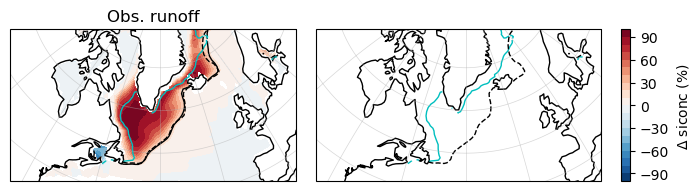

In [ ]:
fig = plt.figure(figsize=(8,8))

projection=ccrs.LambertAzimuthalEqualArea(central_longitude=320, central_latitude=60)
axes_class = (GeoAxes,
                  dict(projection=projection))

obs_contours={'colors':'c', 'linewidths':1}
model_contours={'colors':'k', 'linewidths':1}

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 2),
                    axes_pad=0.2,
                    cbar_location='right',
                    cbar_mode='edge',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05

# siconc
levels=np.arange(-100,101,10)
ax = grid[0]
ax.set_title('Obs. runoff')
ax.contourf(ds_obs_rnf_rm_mar_anom.lon, ds_obs_rnf_rm_mar_anom.lat, 
               ds_obs_rnf_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_obs_rnf_rm_mar.lon, ds_obs_rnf_rm_mar.lat, ds_obs_rnf_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

grid.cbar_axes[0].colorbar(cb_sicn,extend='both', label =r'$\Delta$ siconc (%)')

for ax in grid:
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=0.5, alpha=0.5)
    ax.set_extent([275,0,35,75])
    
    oc = ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **obs_contours)
    #ax.clabel(oc, oc.levels, inline=True)
    mc=ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--', linewidths=1)

KeyboardInterrupt: 

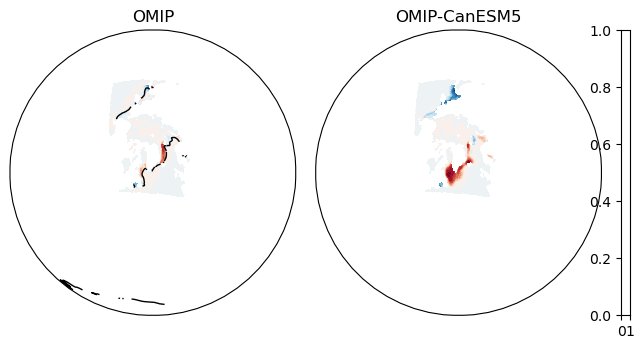

In [23]:
fig = plt.figure(figsize=(8,8))

projection=ccrs.LambertAzimuthalEqualArea(central_longitude=320, central_latitude=60)
axes_class = (GeoAxes,
                  dict(projection=projection))

obs_contours={'colors':'c', 'linewidths':1}
model_contours={'colors':'k', 'linewidths':1}

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 2),
                    axes_pad=0.2,
                    cbar_location='right',
                    cbar_mode='edge',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05

# siconc
levels=np.arange(-100,101,10)
ax = grid[0]
ax.set_title('OMIP')
ax.contourf(ds_omip_ref_rm_mar_anom.lon, ds_omip_ref_rm_mar_anom.lat, 
               ds_omip_ref_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_omip_ref_rm_mar.lon, ds_omip_ref_rm_mar.lat, ds_omip_ref_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

ax = grid[1]
ax.set_title('OMIP-CanESM5')
cb_sicn=ax.contourf(ds_omip_c5fs_rm_mar_anom.lon, ds_omip_c5fs_rm_mar_anom.lat, 
               ds_omip_c5fs_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_omip_c5fs_rm_mar.lon, ds_omip_c5fs_rm_mar.lat, ds_omip_c5fs_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

grid.cbar_axes[0].colorbar(cb_sicn,extend='both', label =r'$\Delta$ siconc (%)')

for ax in grid:
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=0.5, alpha=0.5)
    ax.set_extent([275,0,35,75])
    
    oc = ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **obs_contours)
    #ax.clabel(oc, oc.levels, inline=True)
    mc=ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--', linewidths=1)

In [ ]:
fig = plt.figure(figsize=(12,10))
projection=ccrs.LambertAzimuthalEqualArea(central_longitude=270, central_latitude=60)
#projection=ccrs.LambertConformal(central_longitude=270, central_latitude=60)

#projection=ccrs.PlateCarree()
axl = plt.subplot(1,2,1,projection=projection)

levels=np.arange(-100,101,10)
axl.contourf(siconc_anom_mar_varcons.lon, siconc_anom_mar_varcons.lat, 
               siconc_anom_mar_varcons, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
axl.contour(varcons_ds_rm_mar.lon, varcons_ds_rm_mar.lat, varcons_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axr = plt.subplot(1,2,2,projection=projection)
axr.contourf(siconc_anom_mar_cons02.lon, siconc_anom_mar_cons02.lat, 
               siconc_anom_mar_cons02, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

axr.contour(cons02_ds_rm_mar.lon, cons02_ds_rm_mar.lat, cons02_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axl.set_title('cons=f(density)')
axr.set_title('dens=300, cons=0.2')
#axr.set_title('CanESM5-0_p2')
axl. text(1.1,1.1, 'March concentration anomaly vs NSIDC', transform=axl.transAxes, ha='center', fontweight='bold')
for ax in [axl, axr]:
    ax.coastlines(resolution='110m')
    ax.gridlines()
    ax.set_extent([275,350,50,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--')

fig.savefig('siconc_bias_CanESM5_cons_exps.png', bbox_inches='tight', dpi=300)

: 

In [ ]:
fig = plt.figure(figsize=(12,10))
projection=ccrs.LambertAzimuthalEqualArea(central_longitude=270, central_latitude=60)
#projection=ccrs.LambertConformal(central_longitude=270, central_latitude=60)

#projection=ccrs.PlateCarree()
axl = plt.subplot(1,2,1,projection=projection)

levels=np.arange(-100,101,10)
axl.contourf(siconc_anom_mar_ds_nudge_1950.lon, siconc_anom_mar_ds_nudge_1950.lat, 
               siconc_anom_mar_ds_nudge_1950, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
axl.contour(nudge_1950_mar.lon, nudge_1950_mar.lat, nudge_1950_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axr = plt.subplot(1,2,2,projection=projection)
axr.contourf(siconc_anom_mar_ds_nudge_1980.lon, siconc_anom_mar_ds_nudge_1980.lat, 
               siconc_anom_mar_ds_nudge_1980, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

axr.contour(nudge_1980_mar.lon, nudge_1980_mar.lat, nudge_1980_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axl.set_title('Nudge s1950')
axr.set_title('Nudge s1980')
#axr.set_title('CanESM5-0_p2')
axl. text(1.1,1.1, 'March concentration anomaly vs NSIDC', transform=axl.transAxes, ha='center', fontweight='bold')
for ax in [axl, axr]:
    ax.coastlines(resolution='110m')
    ax.gridlines()
    ax.set_extent([275,350,50,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--')
    
fig.savefig('siconc_bias_CanESM5_nudge_exps1.png', bbox_inches='tight', dpi=300)

: 

In [ ]:
fig = plt.figure(figsize=(12,10))
projection=ccrs.LambertAzimuthalEqualArea(central_longitude=270, central_latitude=60)
#projection=ccrs.LambertConformal(central_longitude=270, central_latitude=60)

#projection=ccrs.PlateCarree()
axl = plt.subplot(1,2,1,projection=projection)

levels=np.arange(-100,101,10)
axl.contourf(siconc_anom_mar_ds_nudge_1950.lon, siconc_anom_mar_ds_nudge_1950.lat, 
               siconc_anom_mar_ds_nudge_1950, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
axl.contour(nudge_1950_mar.lon, nudge_1950_mar.lat, nudge_1950_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axr = plt.subplot(1,2,2,projection=projection)
axr.contourf(siconc_anom_mar_ds_nudge_1990.lon, siconc_anom_mar_ds_nudge_1990.lat, 
               siconc_anom_mar_ds_nudge_1990, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

axr.contour(nudge_1990_mar.lon, nudge_1990_mar.lat, nudge_1990_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

axl.set_title('Nudge s1950')
axr.set_title('Nudge s1990')
#axr.set_title('CanESM5-0_p2')
axl. text(1.1,1.1, 'March concentration anomaly vs NSIDC', transform=axl.transAxes, ha='center', fontweight='bold')
for ax in [axl, axr]:
    ax.coastlines(resolution='110m')
    ax.gridlines()
    ax.set_extent([275,350,50,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--')
fig.savefig('siconc_bias_CanESM5_nudge_exps2.png', bbox_inches='tight', dpi=300)

: 

# Combined experiments figure

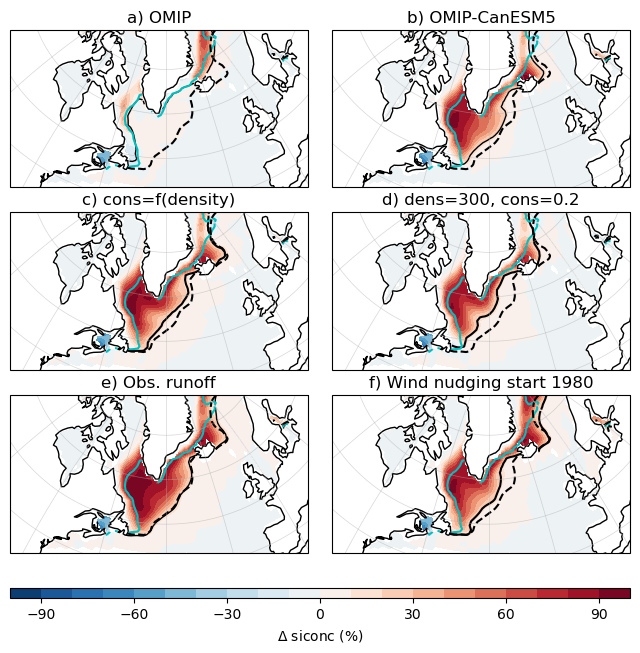

In [15]:
fig = plt.figure(figsize=(8,14))

projection=ccrs.LambertAzimuthalEqualArea(central_longitude=320, central_latitude=60)
axes_class = (GeoAxes,
                  dict(projection=projection))

obs_contours={'colors':'k', 'linewidths':1}
model_contours={'colors':'k', 'linewidths':1}

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 2),
                    axes_pad=0.25,
                    cbar_location='bottom',
                    cbar_mode='single',
                    cbar_pad=0.1,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05

# siconc
levels=np.arange(-100,101,10)

#===================================================================================
# OMIP exp
ax = grid[0]
ax.set_title('a) OMIP')
ax.contourf(ds_omip_ref_rm_mar_anom.lon, ds_omip_ref_rm_mar_anom.lat, 
               ds_omip_ref_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_omip_ref_rm_mar.lon, ds_omip_ref_rm_mar.lat, ds_omip_ref_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

ax = grid[1]
ax.set_title('b) OMIP-CanESM5')
cb_sicn=ax.contourf(ds_omip_c5fs_rm_mar_anom.lon, ds_omip_c5fs_rm_mar_anom.lat, 
               ds_omip_c5fs_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_omip_c5fs_rm_mar.lon, ds_omip_c5fs_rm_mar.lat, ds_omip_c5fs_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

grid.cbar_axes[0].colorbar(cb_sicn,extend='both', label =r'$\Delta$ siconc (%)')
#===================================================================================
# Thermodynamics exps
grid[2].contourf(siconc_anom_mar_varcons.lon, siconc_anom_mar_varcons.lat, 
               siconc_anom_mar_varcons, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
grid[2].contour(varcons_ds_rm_mar.lon, varcons_ds_rm_mar.lat, varcons_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

grid[3].contourf(siconc_anom_mar_cons02.lon, siconc_anom_mar_cons02.lat, 
               siconc_anom_mar_cons02, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

grid[3].contour(cons02_ds_rm_mar.lon, cons02_ds_rm_mar.lat, cons02_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

grid[2].set_title('c) cons=f(density)')
grid[3].set_title('d) dens=300, cons=0.2')
#===================================================================================
ax = grid[4]
ax.set_title('e) Obs. runoff')
ax.contourf(ds_obs_rnf_rm_mar_anom.lon, ds_obs_rnf_rm_mar_anom.lat, 
               ds_obs_rnf_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_obs_rnf_rm_mar.lon, ds_obs_rnf_rm_mar.lat, ds_obs_rnf_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#===================================================================================
ax = grid[5]
ax.contourf(siconc_anom_mar_ds_nudge_1980.lon, siconc_anom_mar_ds_nudge_1980.lat, 
               siconc_anom_mar_ds_nudge_1980, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

ax.contour(nudge_1980_mar.lon, nudge_1980_mar.lat, nudge_1980_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

ax.set_title('f) Wind nudging start 1980')
#===================================================================================

for ax in grid:
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=0.5, alpha=0.5)
    ax.set_extent([275,0,35,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--')
    
fig.savefig('siconc_labsea_exps_CanESM5.png', bbox_inches='tight', dpi=300)

In [17]:
fig = plt.figure(figsize=(8,14))

projection=ccrs.LambertAzimuthalEqualArea(central_longitude=320, central_latitude=60)
axes_class = (GeoAxes,
                  dict(projection=projection))

obs_contours={'colors':'k', 'linewidths':1}
model_contours={'colors':'k', 'linewidths':1}

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 2),
                    axes_pad=0.25,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.1,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05

# siconc
levels=np.arange(-100,101,10)

#===================================================================================
# OMIP exp
ax = grid[0]
ax.set_title('a) OMIP')
ax.contourf(ds_omip_ref_rm_mar_anom.lon, ds_omip_ref_rm_mar_anom.lat, 
               ds_omip_ref_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_omip_ref_rm_mar.lon, ds_omip_ref_rm_mar.lat, ds_omip_ref_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

ax = grid[1]
ax.set_title('b) OMIP-CanESM5')
cb_sicn=ax.contourf(ds_omip_c5fs_rm_mar_anom.lon, ds_omip_c5fs_rm_mar_anom.lat, 
               ds_omip_c5fs_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_omip_c5fs_rm_mar.lon, ds_omip_c5fs_rm_mar.lat, ds_omip_c5fs_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#ax.clabel(mc, mc.levels, inline=True)

grid.cbar_axes[0].colorbar(cb_sicn,extend='both', label =r'$\Delta$ siconc (%)')

for ax in grid:
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=0.5, alpha=0.5)
    ax.set_extent([275,0,35,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--')
    
fig.savefig('siconc_labsea_exps_CanESM5_omip.png', bbox_inches='tight', dpi=300)

In [19]:
fig = plt.figure(figsize=(8,14))

projection=ccrs.LambertAzimuthalEqualArea(central_longitude=320, central_latitude=60)
axes_class = (GeoAxes,
                  dict(projection=projection))

obs_contours={'colors':'k', 'linewidths':1}
model_contours={'colors':'k', 'linewidths':1}

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 2),
                    axes_pad=0.25,
                    cbar_location='bottom',
                    cbar_mode='single',
                    cbar_pad=0.1,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05

# siconc
levels=np.arange(-100,101,10)

#===================================================================================
#===================================================================================
# Thermodynamics exps
grid[0].contourf(siconc_anom_mar_varcons.lon, siconc_anom_mar_varcons.lat, 
               siconc_anom_mar_varcons, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
grid[0].contour(varcons_ds_rm_mar.lon, varcons_ds_rm_mar.lat, varcons_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

grid[1].contourf(siconc_anom_mar_cons02.lon, siconc_anom_mar_cons02.lat, 
               siconc_anom_mar_cons02, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

grid[1].contour(cons02_ds_rm_mar.lon, cons02_ds_rm_mar.lat, cons02_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

grid[0].set_title('a) cons=f(density)')
grid[1].set_title('b) dens=300, cons=0.2')
#===================================================================================
ax = grid[2]
ax.set_title('c) Obs. runoff')
ax.contourf(ds_obs_rnf_rm_mar_anom.lon, ds_obs_rnf_rm_mar_anom.lat, 
               ds_obs_rnf_rm_mar_anom, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())
mc=ax.contour(ds_obs_rnf_rm_mar.lon, ds_obs_rnf_rm_mar.lat, ds_obs_rnf_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), **model_contours)
#===================================================================================
ax = grid[3]
ax.contourf(siconc_anom_mar_ds_nudge_1980.lon, siconc_anom_mar_ds_nudge_1980.lat, 
               siconc_anom_mar_ds_nudge_1980, levels=levels, cmap='RdBu_r',
               transform=ccrs.PlateCarree())

ax.contour(nudge_1980_mar.lon, nudge_1980_mar.lat, nudge_1980_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k')

ax.set_title('d) Wind nudging start 1980')
#===================================================================================
grid.cbar_axes[0].colorbar(cb_sicn,extend='both', label =r'$\Delta$ siconc (%)')

for ax in grid:
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=0.5, alpha=0.5)
    ax.set_extent([275,0,35,75])
    ax.contour(siconc_NSIDC_nh_rm_mar.lon, siconc_NSIDC_nh_rm_mar.lat, siconc_NSIDC_nh_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='c')
    ax.contour(canesm5p2_ds_rm_mar.lon, canesm5p2_ds_rm_mar.lat, canesm5p2_ds_rm_mar, [15], 
                   transform=ccrs.PlateCarree(), colors='k', linestyles='--')
    
fig.savefig('siconc_labsea_exps_CanESM5_cpl.png', bbox_inches='tight', dpi=300)